<a href="https://colab.research.google.com/github/RiverTwilight/Awesome-Machine-Learning-Playground/blob/master/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This shows how to process

Note: It's recommend to read the [Handwritten_Digits_Detection]() first. Some basic concepts and codes are explained there.

In [ ]:
!pip install kora -q
from kora import drive
drive.link_nbs()
from Handwritten_Digits_Detection import Relu, Affine, AdaGard

# Data Process

In order to put the complex the data into neural network, the most-used solution is to convert the data to vector space. In this part we'll discuss how to convert the natural text data into vectors.

## Word co-occurrence matrix

Usually the meaning of a word depends on the context. A word co-occurrence matrix reprents how many times has a word appear around another word. 

Consider this sentence:
```markdown
 You are my friend and I am his friend. 
```
First we remove the duplicate words and we can create a table like this:

\begin{array}{ccc}
\text{ }&\text{You}&\text{are}&\text{my}&\text{friend}&\text{and}&\text{I}&\text{am}&\text{his}&\text{.}\\
\text{You}&\text{0}&\text{1}&\text{0}&\text{0}&\text{0}&\text{0}&\text{0}&\text{0}&\text{0}\\
\text{are}\\
\text{my}\\
\text{friend}\\
\text{and}\\
\text{I}\\
\text{am}\\
\text{his}\\
\end{array}


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def postprocess(text):
    text = text.lower()
    text = text.replace('.', " .")

    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        new_id = len(word_to_id)
        word_to_id.setdefault(word, new_id)
        id_to_word.setdefault(new_id, word)
    
    corpus = [word_to_id[w] for w in words]
    corpus = np.array(corpus)

    return (word_to_id, id_to_word, corpus)

def create_co_matrix(corpus, vocab_size, windows_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(windows_size):
            left_idx = idx - 1
            right_idx = idx + 1

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

(word_to_id, id_to_word, corpus) = postprocess("You are my friend and I am his friend.")

C = create_co_matrix(corpus, len(corpus), 1)

But this doesn't represnet the link between word very well. Thus we introduced the PMI. The $P(x)$ denote the probablity of the event x.

$$ PMI(x, y) = log_{2}\frac{P(x, y)}{P(x)P(y)} $$

But as the volcabulary grows, use a 2-dimension array like this is not efficient.

$$ X=USV^{t} $$

[[-3.846e-01 -5.220e-01 -4.094e-01  7.078e-16  2.816e-01 -2.196e-01
   7.934e-17  1.349e-01 -5.161e-01  0.000e+00]
 [-4.941e-01  6.541e-01 -4.806e-01 -1.765e-17 -2.653e-01 -1.585e-01
  -7.224e-18 -4.055e-02  0.000e+00  0.000e+00]
 [-3.654e-01 -4.348e-01 -2.261e-01  1.801e-16 -4.631e-02  1.537e-01
  -1.498e-16 -1.792e-01  7.539e-01  0.000e+00]
 [-3.556e-01  2.632e-01  1.722e-01  1.026e-16  6.102e-01  5.944e-01
   4.200e-17  2.212e-01  0.000e+00  0.000e+00]
 [-2.604e-01 -9.605e-02  2.938e-01 -3.717e-01 -3.444e-01 -1.847e-02
   6.015e-01  4.665e-01  0.000e+00  0.000e+00]
 [-2.971e-01  3.393e-02  4.110e-01  6.015e-01  1.449e-01 -3.400e-01
   3.717e-01 -3.242e-01  1.110e-16  0.000e+00]
 [-2.971e-01  3.393e-02  4.110e-01 -6.015e-01  1.449e-01 -3.400e-01
  -3.717e-01 -3.242e-01 -1.110e-16  0.000e+00]
 [-2.604e-01 -9.605e-02  2.938e-01  3.717e-01 -3.444e-01 -1.847e-02
  -6.015e-01  4.665e-01 -2.776e-16  0.000e+00]
 [-1.895e-01 -1.438e-01  1.004e-01 -5.551e-16 -4.434e-01  5.638e-01
  -1.110e-16

<ipython-input-11-adf6c5d89f16>:10: RuntimeWarning: invalid value encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)


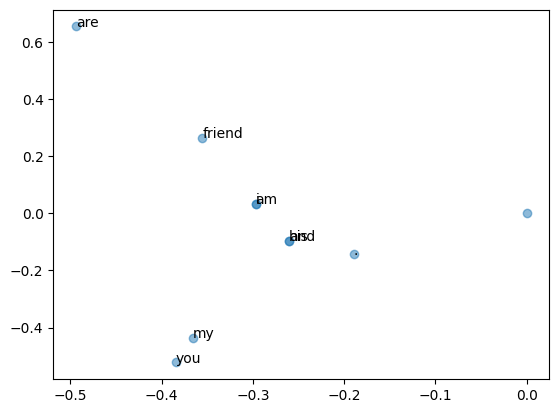

In [11]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100+1) == 0:
                    print('%.1f%% done' % (100*cnt/total))

    return M

np.set_printoptions(precision=3)
W = ppmi(C)

U, S, V = np.linalg.svd(W)
print(U) 
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:, 1], alpha=0.5)
plt.show()

## Similarity

Our goal is to implement the sentence based on the context. So we have to calculate the similarity between the words.

For example, we want the machine know that "I", "You" and "He" are simliary words in the English. This part we will calc the similarity of vectors.

# Layers

adsfasdfas

# Training



# Reference

1. Saito Kokih. Deep Learning from Scratch 2: Natural Language Processing[M]. Japan: O'Reilly Japan, 2018.

2. Khelifi Ahmed Aziz. Medium. Learn How to Write Markdown & LaTeX in The Jupyter Notebook (https://towardsdatascience.com/write-markdown-latex-in-the-jupyter-notebook-10985edb91fd)